In [1]:
from compare_adversarial import *

In [2]:
alpha = 0.01
num_iterations = 10
num_test_samples = 100

validator = VAEValidation()
cnn = load_model("trained_models/classifier.h5")
# input shape: (28, 28, 1)

# Load models
# vae = VAE.load("trained_models/epoch_200")
cae = CAE.load("trained_models/epoch_200")
cvae = C_VAE.load("trained_models/epoch_100")

# models = [vae, cae, cvae]
models = [cae, cvae]
model_names = ["cae", "cvae"]
# model_names = ["vae", "cae", "cvae"]
# adversarial_methods = ["forward_gradient", "bp_gradient", "vanilla"]
adversarial_methods = ["forward_gradient"]

# Create LavaMultiSteps instances
lava_instances = {}
for model, prefix in zip(models, model_names):
    for method in adversarial_methods:
        key = f"lava_{prefix}_{method}"
        lava_instances[key] = LavaMultiSteps(cnn, model.encoder, model.decoder, adversarial_method=method,
                                             verbose=True)

# Load input images
samples, sample_labels, sample_indices = load_samples_for_test(num_test_samples, return_indices=True)
y_onehot = tf.one_hot(tf.constant(sample_labels), depth=10).numpy()

2024-06-23 11:47:51.612293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-23 11:47:51.621155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-23 11:47:51.621683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-23 11:47:51.622897: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [3]:
image = samples[0]
image_label = y_onehot[0]

In [4]:
x = np.reshape([image], (1, 784,))

In [5]:
h = cae.encoder.predict(x)[0]
x_label = np.array([image_label])
h_cvae = cvae.encoder.predict([x, x_label])[0][:cvae.decoder.input_shape[0][-1]]

2024-06-23 11:47:53.720301: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2024-06-23 11:47:54.097863: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2024-06-23 11:47:54.447473: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(12,) [0.56665194 2.4791617  1.8093262  0.90466803 0.         0.
 1.2759504  2.1382518  1.1665597  0.         2.0393975  2.84016   ]
(12,) [0.56665194 2.4791617  1.8093262  0.90466803 0.         0.
 1.2759504  2.1382518  1.1665597  0.         2.0393975  2.84016   ]


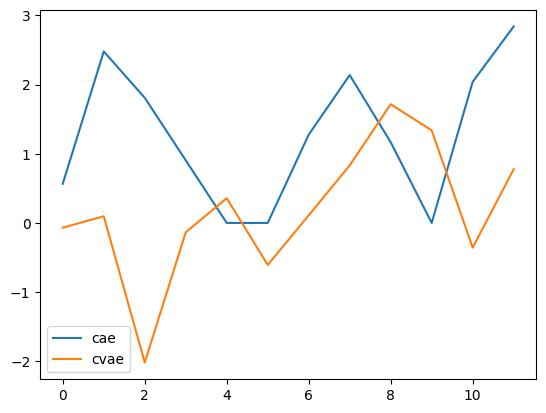

In [6]:
print(h.shape, h)
plt.plot(h, label="cae")
print(h_cvae.shape, h)
plt.plot(h_cvae, label="cvae")
plt.legend()

In [7]:
for name, lava in lava_instances.items():
    if "cvae" in name:
        x = np.array([h])
    else:
        x = np.array([h_cvae])
    
    y = np.array([image_label])
    h_delta = lava.adversarial(x, y, lava.xai)
    print(name, h_delta)
    plt.plot(h_delta, label=name)

plt.legend()

AttributeError: 
        'EagerTensor' object has no attribute 'ravel'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()

In [22]:
def forward_gradient_of_input(model, input_data, output_data):
    delta = 1e-5
    g = np.zeros(input_data.shape[-1])
    g_tmp = np.zeros(input_data.shape[-1])
    for i in range(len(g)):
        x_delta = np.copy(g_tmp)
        x_delta[i] = 1
        input_data_2 = input_data + x_delta * delta
        if isinstance(model.input_shape, list):
            predictions = model([input_data, output_data], training=False)
            predictions_2 = model([input_data_2, output_data], training=False)
        else:
            predictions = model(input_data, training=False)
            predictions_2 = model(input_data_2, training=False)

        loss = tf.keras.losses.categorical_crossentropy(output_data, predictions)
        loss_2 = tf.keras.losses.categorical_crossentropy(output_data, predictions_2)
        loss_delta = loss_2 - loss
        g[i] = loss_delta / delta
    return g

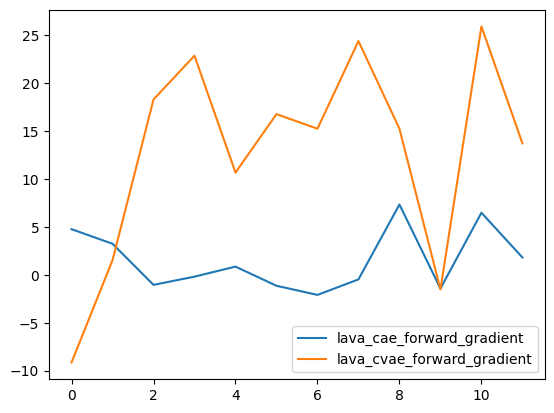

In [23]:
for name, lava in lava_instances.items():
    if "cvae" in name:
        x = np.array([h])
    else:
        x = np.array([h_cvae])
    
    y = np.array([image_label])
    model = lava.remove_last_softmax_activation(lava.xai)

    input_data = tf.convert_to_tensor(x, dtype=tf.float32)
    true_labels = tf.convert_to_tensor(y, dtype=tf.float32)
    h_delta = forward_gradient_of_input(model, input_data, true_labels)
    plt.plot(h_delta, label=name)

plt.legend()